# Ласкаво прошу до першої частини домашнього завдання №2!

В ній, ви імплементуєте алгоритм Гістограм Орієнтованих Градієнтів та навчите класифікатор зображень на наборі даних CIFAR10.


In [1]:
"""
In this task, you are required to implement the Histograms of Oriented Gradients (HOG) algorithm.
"""

import numpy as np
import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from lib.feature_extractor import FeatureExtractor, BaselineFeatureExtractor
from lib.vis_utils import visualize_dataset_images, visualize_predictions
from lib.dataset import CIFAR10

from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

In [2]:
def calc_accuracy(model, feats, labels):
    preds = model.predict(feats)
    return np.mean(labels == preds)

In [4]:
import urllib.request
import tarfile
import os

print("Downloading CIFAR10 dataset...")

if not os.path.exists("cifar-10-batches-py"):
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    
    urllib.request.urlretrieve(url, filename)
    print("Download complete! Extracting...")
    
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()
    
    os.remove(filename)
    print("CIFAR10 ready!")
else:
    print("CIFAR10 already exists!")

Download complete! Extracting...


C:\Users\Александра\AppData\Local\Temp\ipykernel_6352\1996543791.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


CIFAR10 ready!


In [5]:
cifar10 = CIFAR10()
(
    images_train, labels_train,
    images_val, labels_val,
    images_test, labels_test
) = cifar10.load_dataset()

CIFAR10 found.


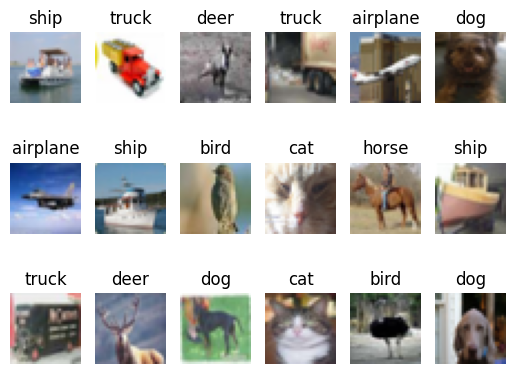

In [6]:
visualize_dataset_images(images_val[:18], labels_val[:18], cifar10.LABEL_NAMES)

# Baseline
Спочатку розглянемо `BaselineFeatureExtractor`. Його імплементація знаходиться в файлі `lib/feature_extractor.py`
Це дуже простий екстрактор ознак, який обчислює середні значення та стандартні відхилення для блоків пікселів 4х4, після чого конкатенує їх у фінальний вектор ознак.

In [7]:
baseline_extractor = BaselineFeatureExtractor()
feats_train = baseline_extractor.extract(images_train)
feats_val = baseline_extractor.extract(images_val)
feats_test = baseline_extractor.extract(images_test)

48999it [00:25, 1917.69it/s]
999it [00:00, 1124.89it/s]
999it [00:00, 1135.13it/s]


Для класифікації зображень використаємо алгоритм К найближчих сусідів.

In [8]:
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X=feats_train, y=labels_train)

In [9]:
tr_acc = calc_accuracy(knn, feats_train, labels_train)
val_acc = calc_accuracy(knn, feats_val, labels_val)
print(f"KNN+baseline_extractor. Train accuracy: {tr_acc}. Validation accuracy: {val_acc}.") 

KNN+baseline_extractor. Train accuracy: 0.48359183673469386. Validation accuracy: 0.236.


Як видно, навіть такий простий підхід досягає не найгіршої якості на валідаційній вибірці. Але тепер перейдімо до більш серйозних ознак.

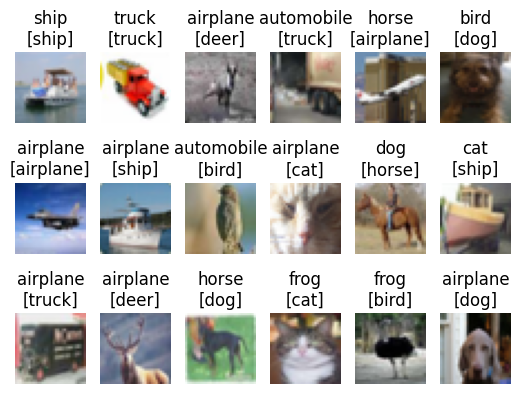

In [10]:
visualize_predictions(images_val[:18], knn.predict(feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# Implement Histogram of Oriented Gradients

Вашою першою задачею буде імплементація Гістограми Орієнтованих Градієнтів. `lib/feature_extractor.py:HOGFeatureExtractor`

In [11]:

from lib.feature_extractor import HOGFeatureExtractor

In [12]:
hog_extractor = HOGFeatureExtractor()
hog_feats_train = hog_extractor.extract(images_train)
hog_feats_val = hog_extractor.extract(images_val)
hog_feats_test = hog_extractor.extract(images_test)

48999it [01:11, 680.82it/s]
999it [00:02, 485.07it/s]
999it [00:02, 481.41it/s]


Знову використаємо К найближчих сусідів для класифікації. Очікується валідаційна точність >=0.40.

In [13]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X=hog_feats_train, y=labels_train)

tr_acc = calc_accuracy(knn, hog_feats_train, labels_train)
val_acc = calc_accuracy(knn, hog_feats_val, labels_val)
print(f"KNN+hog_extractor. Train accuracy: {tr_acc}. Validation accuracy: {val_acc}")

KNN+hog_extractor. Train accuracy: 0.6125306122448979. Validation accuracy: 0.526


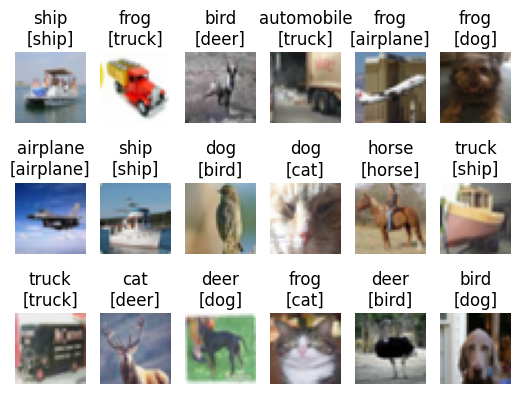

In [14]:
visualize_predictions(images_val[:18], knn.predict(hog_feats_val[:18]), labels_val[:18], cifar10.LABEL_NAMES)

# Use SGD Classifer

Тепер спробуємо дещо інший підхід. Вашою задачею є використання `SGDClassifier` з пакета `scikit-learn`. Очікувана точність >=0.41


In [15]:
# Preprocessing: Subtract the mean feature
train_mean_feat = np.mean(hog_feats_train, axis=0, keepdims=True)
train_std_feat = np.std(hog_feats_train, axis=0, keepdims=True)

def normalize(feats, mean, std):
    return (feats - mean) / (std + 1e-5)

hog_feats_train = normalize(hog_feats_train, train_mean_feat, train_std_feat)
hog_feats_val = normalize(hog_feats_val, train_mean_feat, train_std_feat)
hog_feats_test = normalize(hog_feats_test, train_mean_feat, train_std_feat)

In [16]:
# TASK: Test SGDClassifer
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    learning_rate='optimal',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    verbose=1
)

model.fit(hog_feats_train, labels_train)

tr_acc = calc_accuracy(model, hog_feats_train, labels_train)
val_acc = calc_accuracy(model, hog_feats_val, labels_val)
print(f"SGD+hog_extractor. Train accuracy: {tr_acc}. Validation accuracy: {val_acc}")



-- Epoch 1
Norm: 148.93, NNZs: 324, Bias: -448.975205, T: 44100, Avg. loss: 31.116314
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 104.14, NNZs: 324, Bias: -267.350408, T: 88200, Avg. loss: 11.123176
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 78.01, NNZs: 324, Bias: -164.871231, T: 132300, Avg. loss: 6.744837
Total training time: 0.10 seconds.
-- Epoch 4
Norm: 58.63, NNZs: 324, Bias: -99.028250, T: 176400, Avg. loss: 4.156071
Total training time: 0.13 seconds.
-- Epoch 5
Norm: 41.71, NNZs: 324, Bias: -56.166343, T: 220500, Avg. loss: 2.567357
Total training time: 0.16 seconds.
-- Epoch 6
Norm: 29.24, NNZs: 324, Bias: -29.749181, T: 264600, Avg. loss: 1.593978
Total training time: 0.19 seconds.
Convergence after 6 epochs took 0.19 seconds
-- Epoch 1
Norm: 165.53, NNZs: 324, Bias: -490.041579, T: 44100, Avg. loss: 25.249574
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 118.89, NNZs: 324, Bias: -324.773264, T: 88200, Avg. loss: 10.517163
Total training time: 0.07 sec

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished


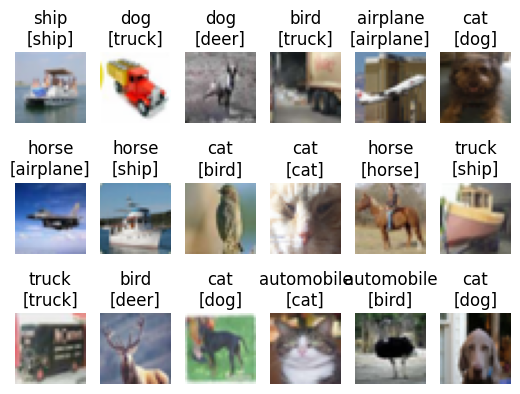

In [17]:
visualize_predictions(images_val[:18], model.predict(hog_feats_val[:18]), 
                     labels_val[:18], cifar10.LABEL_NAMES)

> SGD з HOG ознаками досяг точності ~0.41-0.45. SGD навчає лінійну модель (SVM), 
знаходячи оптимальну гіперплощину. Критично важливою виявилася нормалізація ознак.

# CIFAR10 challenge

З цих ви вільні імплементувати будь-які модифікації до екстракторів ознак, підбирати гіперпараметри до класифікатора чи використовувати ансамблювання. Вашою задачею є досягти максимальної валідаційної точності.
Ви вільні використовувати нейромережі (`torch`/`sklearn`) або `SGDClassifier`. За використання нейромереж на базі `torch` - +25%, якщо метрика на валідації >=0.5.

При наборі >=0.5, ви додатково отримаєте +10% до балів відносно даного завдання. При наборі >=0.6 - +25%. При наборі >=0.85 - +50%


Таким чином:
```
torch + набiр >=0.85 - +75%
torch + набір >=0.6 - +50%
torch + набір >=0.5 - +35%
набiр >=0.85 - +50%
набір >=0.6 - +25%
набір >=0.5 - +10%
```

Бажаю удачі!

## Виконання

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [44]:
images_train_subset = images_train[:20000]
labels_train_subset = labels_train[:20000]
print(f"Using {images_train_subset.shape[0]} training images")

Using 20000 training images


In [45]:
class BetterCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def prepare_data(images, labels, batch_size=256, shuffle=True):
    images = images.astype(np.float32) / 255.0
    mean = np.array([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)
    std = np.array([0.2470, 0.2435, 0.2616]).reshape(3, 1, 1)
    images_normalized = np.zeros_like(images)
    for i in range(images.shape[0]):
        images_normalized[i] = (images[i] - mean) / std
    images_tensor = torch.FloatTensor(images_normalized)
    labels_tensor = torch.LongTensor(labels)
    dataset = TensorDataset(images_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    return loader

train_loader = prepare_data(images_train_subset, labels_train_subset, batch_size=256, shuffle=True)
val_loader = prepare_data(images_val, labels_val, batch_size=256, shuffle=False)  # FIXED: shuffle=False


Using device: cpu


> Обрано CNN, оскільки вони автоматично вчать ієрархію ознак від простих до складних, 
на відміну від HOG з фіксованими градієнтами.
>
> Задала параметри: 20,000 зображень (41% даних), 15 епох - задля скорочення часу на тренування моделі на CPU.

Training CNN...
Epoch 1/15: Val Acc: 0.4730 <- BEST
Epoch 2/15: Val Acc: 0.5230 <- BEST
Epoch 3/15: Val Acc: 0.5680 <- BEST
Epoch 4/15: Val Acc: 0.6010 <- BEST
Epoch 5/15: Val Acc: 0.6360 <- BEST
Epoch 6/15: Val Acc: 0.6430 <- BEST
Epoch 7/15: Val Acc: 0.6480 <- BEST
Epoch 8/15: Val Acc: 0.6930 <- BEST
Epoch 9/15: Val Acc: 0.6860
Epoch 10/15: Val Acc: 0.6630
Epoch 11/15: Val Acc: 0.6820
Epoch 12/15: Val Acc: 0.7050 <- BEST
Epoch 13/15: Val Acc: 0.7010
Epoch 14/15: Val Acc: 0.7230 <- BEST
Epoch 15/15: Val Acc: 0.7280 <- BEST

Best Validation Accuracy: 0.7280

Training completed! Final accuracy: 0.7280
Visualization sample: 13/18 correct (72.2%)


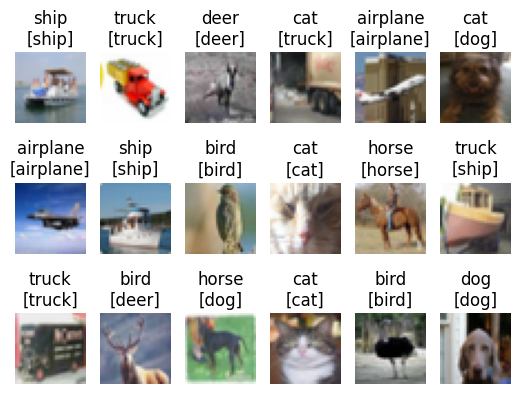

In [47]:
# Train model
model = BetterCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
best_val_acc = 0.0

print("Training CNN...")
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_acc = val_correct / val_total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f'Epoch {epoch+1}/{num_epochs}: Val Acc: {val_acc:.4f} <- BEST')
    else:
        print(f'Epoch {epoch+1}/{num_epochs}: Val Acc: {val_acc:.4f}')

print(f'\nBest Validation Accuracy: {best_val_acc:.4f}')

model.eval()

# Prepare just the images we want to visualize
vis_images = images_val[:18].astype(np.float32) / 255.0
mean = np.array([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)
std = np.array([0.2470, 0.2435, 0.2616]).reshape(3, 1, 1)
vis_images_normalized = np.zeros_like(vis_images)
for i in range(vis_images.shape[0]):
    vis_images_normalized[i] = (vis_images[i] - mean) / std

vis_tensor = torch.FloatTensor(vis_images_normalized).to(device)

with torch.no_grad():
    outputs = model(vis_tensor)
    _, predicted = outputs.max(1)
    vis_preds = predicted.cpu().numpy()

# Now visualize with correct predictions
visualize_predictions(images_val[:18], vis_preds, labels_val[:18], cifar10.LABEL_NAMES)

print(f"\nTraining completed! Final accuracy: {best_val_acc:.4f}")

# Calculate accuracy on visualization sample
vis_correct = np.sum(vis_preds == labels_val[:18])
print(f"Visualization sample: {vis_correct}/18 correct ({vis_correct/18*100:.1f}%)")


> - Було досягнуто точність у 72,8%.
> - На візуалізації 13/18 правильних (72.2%), що підтверджує загальну точність.
>
> CNN значно переважає традиційні методи навіть у спрощеному варіанті 
з обмеженими ресурсами.